In [22]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, interact, Button, VBox, HBox, Output, Layout, IntSlider
from lidar_processing import lidar_processor as LP


In [23]:
def parse_tmca_file(file_path, merged_windows):
    xrf_scans = {}
    ts = 0
    stack_counts = None
    current_window_idx = 0
    x = 0

    with open(file_path, 'r') as file:
        start_x, end_x = merged_windows[current_window_idx][:2]
        ts_min = 0
        ts = 0
        ts_max = np.inf
    
        for line in file:
            line = line.strip()

            if line.startswith("Position:"):
                x = float(line.split("Position:")[1].strip())

                while x < end_x:
                    if stack_counts is not None:
                        ts_max = ts
                        period = ts_max - ts_min
                        stack_counts = stack_counts.astype(float) / np.sum(stack_counts[565:567])
                        xrf_scans[(start_x, end_x)] = [stack_counts,period]
                        stack_counts = None
                    current_window_idx += 1
                    if current_window_idx >= len(merged_windows):
                        return xrf_scans  
                    start_x, end_x = merged_windows[current_window_idx][:2]

            elif line.startswith("TimeStamp:"):
                
                ts_str = line.split("TimeStamp:")[1].strip()
                time_part = ts_str.split("T")[1].split("-")[0]
                h, m, s = map(float, time_part.split(":"))
                ts = h * 3600 + m * 60 + s
                if stack_counts is None:
                    ts_min = ts

            elif line.startswith("Channels:"):
                channels_str = line.split("Channels:")[1].strip()
                channels = np.array([int(ch) for ch in channels_str.split(",")])
                if stack_counts is None:
                    stack_counts = channels
                else:
                    stack_counts += channels

        if stack_counts is not None and current_window_idx < len(merged_windows):
            ts_max = ts
            period = ts_max - ts_min
            stack_counts = stack_counts.astype(float) / np.sum(stack_counts[565:567])
            xrf_scans[(start_x, end_x)] = [stack_counts,period]
            stack_counts = None

    return xrf_scans


In [24]:
def plot_clearance(lp):
    point_cloud = lp._get_data_cube()
    file_path = lp.file_path
    x_start = lp.x_start
    x_stop = lp.x_stop


    xrf_movement_fpath =  os.path.join(os.path.join(file_path, ".XRAY_DPP_001.xrf_position"))
    with open(xrf_movement_fpath, 'r') as file:
        lines = file.readlines()

    lidar_x = point_cloud[:,0]
    lidar_y = point_cloud[:,1]
    lidar_z = point_cloud[:,2]

    y_tolerance = 1/10

    indices = np.where(np.abs(lidar_y) < y_tolerance)

    lidar_x = lidar_x[indices]
    lidar_z = lidar_z[indices]

    xrf_x = []
    xrf_z = []
    z_offset = {}

    for line in lines:
        if "X," in line:
            x = (float)(line.split(',')[1])
            if ( x < x_start and x > x_stop):
                xrf_x.append(x)
        elif "Z," in line:
            z = (float)(line.split(',')[1])
            if ( x < x_start and x > x_stop):
                xrf_z.append(z)

    while(len(xrf_x) > len(xrf_z)):
        xrf_x.pop()

    for i in range (len(xrf_x)):

        x = xrf_x[i]
        z = xrf_z[i]

        lidar_index = np.argmin(np.abs(lidar_x - x))
        offset = lidar_z[lidar_index] - z

        z_offset[x] = offset

    plt.figure(figsize=(150,10))
    plt.xticks(np.arange(x_stop, x_start + 1, 10), fontsize = 30, rotation = 60)
    
    plt.margins(x=0)
    plt.hlines(10, x_start, x_stop, color='black', linewidth=5, label='lidar')
    plt.plot(list(z_offset.keys()), list(z_offset.values()), linewidth=5, color='red', label='clearance')

    plt.show()



In [25]:
def xrf_windows_view(lp, file_path, scale_factor=1.0, offset_factor=0.0, merged=False):
    import os
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt
    from ipywidgets import FloatSlider, Layout, Button, Output, HBox, interact

    log_state = {"logarithmic": True} 

    correction_windows = lp.correction_windows

    if merged:
        merged_windows = {}
        corr_keys = sorted(correction_windows.keys(), key=lambda k: k[0])

        def get_sect_type(key):
            vals = correction_windows[key]
            if vals is None:
                return None
            if vals[3] > 0: return 3  # rubble
            if vals[0] > 0: return 0  # half
            if vals[1] > 0: return 1  # full
            if vals[2] > 0: return 2  # empty

        i = 0
        while i < len(corr_keys):
            start_x = corr_keys[i][0]
            current_perc = get_sect_type(corr_keys[i])
            section = []
            j = i
            while j < len(corr_keys):
                next_perc = get_sect_type(corr_keys[j])
                if next_perc != current_perc:
                    break
                section.append(correction_windows[corr_keys[j]])
                j += 1

            end_x = corr_keys[j - 1][1]
            avg_vals = np.median([vals[4:7] for vals in section], axis=0)
            label_vector = [0, 0, 0, 0]
            label_vector[current_perc] = 1
            merged_windows[(start_x, end_x)] = label_vector + avg_vals.tolist()
            i = j

        correction_windows = merged_windows

    corr_keys = [tuple(reversed(k)) for k in sorted(correction_windows.keys(), key=lambda k: k[0], reverse=True)]
    xrf_scans = parse_tmca_file(os.path.join(file_path, "XRAY_DPP_001.tmca"), corr_keys)
    x_positions = sorted({val for k in xrf_scans for val in (k[0], k[1])})

    saved_profiles = []
    out = Output()
    current_data = [None]

    def plot_profile(x, x_cutoff_max, x_cutoff_min, line = None):
        out.clear_output()
        with out:
            type_labels = ["half", "full", "empty", "rubble"]
            plt.figure(figsize=(35, 10), dpi=150)

            for data in saved_profiles:
                spectrum = np.log(data[2]) if log_state["logarithmic"] else data[2]
                plt.plot(spectrum, label=f"XRF Spectrum: {data[0]:.2f} mm to {data[1]:.2f} mm, period={data[3]:.3f}s, type = {data[4]}")

            for start_x, end_x in correction_windows.keys():
                if start_x <= x <= end_x:
                    channels, ts = xrf_scans[(end_x, start_x)]
                    if channels is not None:
                        label = correction_windows[start_x, end_x][:4]
                        label = np.argmax(label)
                        spectrum = np.log(channels) if log_state["logarithmic"] else channels
                        plt.title(f"XRF Spectra", fontsize=20)
                        plt.plot(spectrum, linestyle='-', label=f"XRF Spectrum: {start_x:.2f} mm to {end_x:.2f} mm, period={ts:.3f}s, type = {type_labels[label]}")
                        current_data[:] = [start_x, end_x, channels, ts, type_labels[label]]
                    break

            ticks = np.arange(x_cutoff_min, x_cutoff_max, (x_cutoff_max - x_cutoff_min) / 200)
            plt.xticks(
                ticks=ticks,
                labels=[f"{tick * scale_factor + offset_factor:.2f}" for tick in ticks],
                rotation=70
            )

            plt.xlim(x_cutoff_min, x_cutoff_max)
            if line is not None:
                min = np.nanmin(np.log(channels[x_cutoff_min:x_cutoff_max][channels[x_cutoff_min:x_cutoff_max] > 0]))
                plt.vlines(ymin = min, ymax = np.log(channels[line]), x = line, color='red', linestyle='--', label=f"{line * scale_factor + offset_factor:.2f} kEv")
            plt.xlabel('kEv')
            plt.ylabel('Intensity')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

            for start_x, end_x in correction_windows.keys():
                if start_x <= x <= end_x:
                    values = correction_windows[start_x, end_x]
                    print(f"Correction values from {start_x:.2f} mm to {end_x:.2f} mm:")
                    labels = ["half_perc", "full_perc", "empty_perc", "rubble_perc", "var", "x_ang", "y_ang"]
                    for label, val in zip(labels, values):
                        print(f"  {label} = {val}")
                    break

    def save_current_plot(_):
        if current_data[0] is not None:
            saved_profiles.append(current_data.copy())
            plot_profile(slider.value, cutoff_slider_max.value, cutoff_slider_min.value)

    def clear_saved_profiles(_):
        saved_profiles.clear()
        plot_profile(slider.value, cutoff_slider_max.value, cutoff_slider_min.value)

    def enable_logarithmic(_):
        log_state["logarithmic"] = True
        plot_profile(slider.value, cutoff_slider_max.value, cutoff_slider_min.value)

    def disable_logarithmic(_):
        log_state["logarithmic"] = False
        plot_profile(slider.value, cutoff_slider_max.value, cutoff_slider_min.value)

    slider = FloatSlider(
        min=min(x_positions),
        max=max(x_positions),
        step=0.01,
        continuous_update=False,
        layout=Layout(width='1900px')
    )

    cutoff_slider_max = IntSlider(
        min=0,
        max=2048,
        continuous_update=False,
        value=2048,
        description="X Cutoff (channels)",
        layout=Layout(width='500px')
    )

    cutoff_slider_min = IntSlider(
        min=0,
        max=2048,
        continuous_update=False,
        value=0,
        description="X Cutoff (channels)",
        layout=Layout(width='500px')
    )

    line_slider = IntSlider(
        min=0,
        max=2048,
        continuous_update=False,
        value=565,
        description="line position",
        layout=Layout(width='500px')
    )

    save_button = Button(description="Save Current Spectrum")
    save_button.on_click(save_current_plot)

    clear_button = Button(description="Clear Saved Spectra")
    clear_button.on_click(clear_saved_profiles)

    ln_button = Button(description="Logarithmic Scale")
    ln_button.on_click(enable_logarithmic)

    lin_button = Button(description="Linear Scale")
    lin_button.on_click(disable_logarithmic)

    interact(plot_profile, x=slider, x_cutoff_max=cutoff_slider_max, x_cutoff_min=cutoff_slider_min, line = line_slider)
    display(HBox([save_button, clear_button, ln_button, lin_button]), out)


c:\Users\eashenhurst\Python\test\LP_env\lib\site-packages\lidar_processing\lidar_processing.py:369: RuntimeWarning: divide by zero encountered in log
  array_i = cp.array(np.log(np.abs(self.intensity_cloud)), dtype=cp.float32)


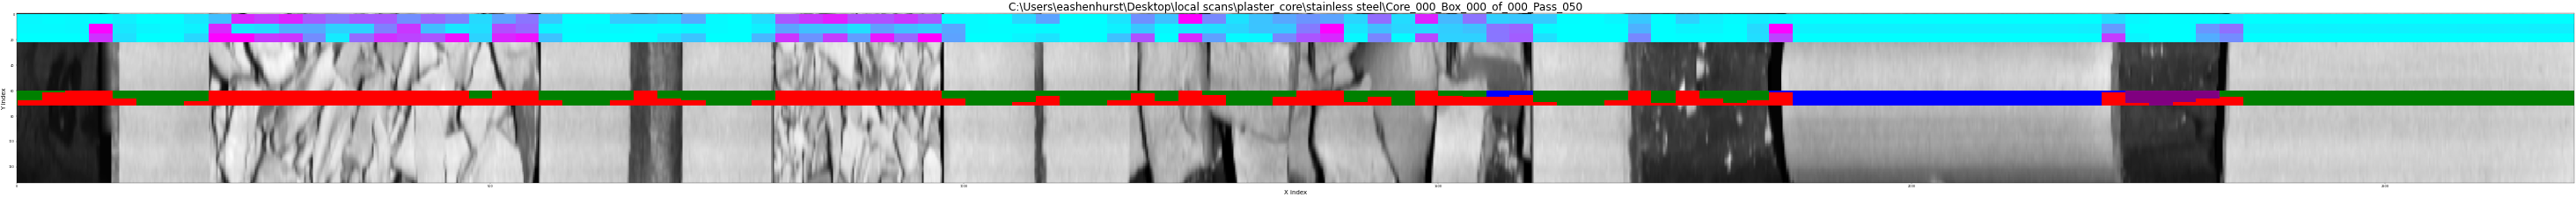

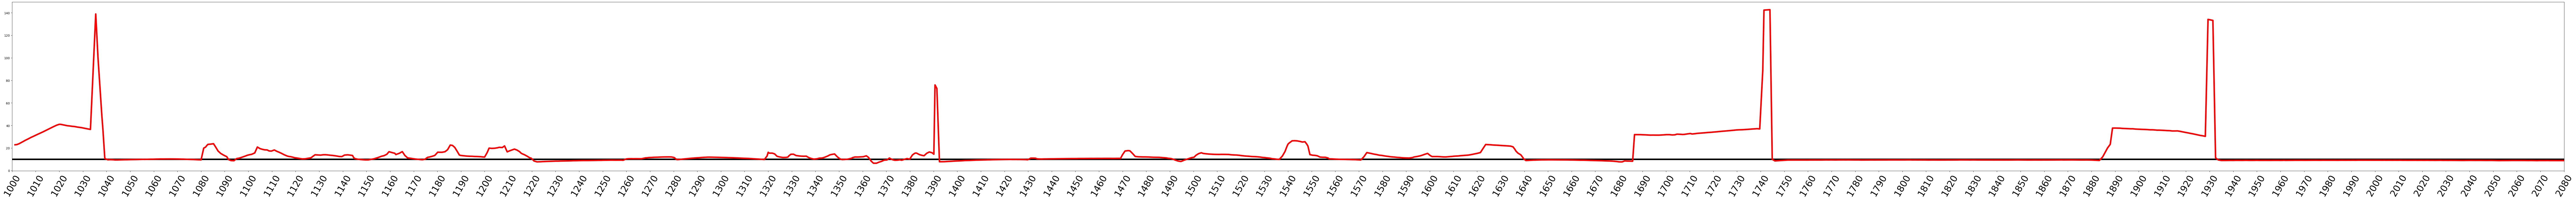

interactive(children=(FloatSlider(value=1000.0096025390625, continuous_update=False, description='x', layout=L…

Output()

In [26]:
sf = 0.01613
of = 0.2475

path = r"C:\Users\eashenhurst\Desktop\local scans\plaster_core\stainless steel\Core_000_Box_000_of_000_Pass_050"

lp = LP(path, window_size = 10, noise_threshold=1)
lp._plot_correction_windows(xrf_window_size = 10, height = 10, dpi = 25)
plot_clearance(lp)
xrf_windows_view(lp, path, sf, of, merged = True)